In [53]:
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam

In [153]:
IMAGE_SIZE = 256
CHANNEL = 3
EPOCHS = 15
BATCH_SIZE = 32

In [154]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/admin/Downloads/DSGP/Data Set",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names = dataset.class_names

Found 10160 files belonging to 3 classes.


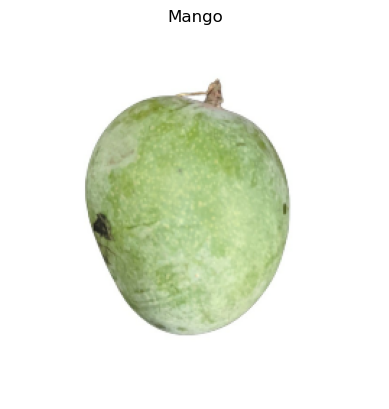

In [155]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [156]:
def get_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [157]:
train_ds, val_ds, test_ds = get_dataset(dataset)

In [158]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [159]:
resize = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])

In [160]:
class ResNetBlock(Layer):

  def __init__(self, out_channels, first_stride=1):
    super().__init__()

    first_padding = 'same'
    if first_stride != 1:
      first_padding = 'valid'
    
    self.conv_sequence = Sequential([
        Conv2D(out_channels, 3, first_stride, padding=first_padding),
        BatchNormalization(),
        ReLU(),

        Conv2D(out_channels, 3, 1, padding='same'),
        BatchNormalization(),
        ReLU()
    ])

  def call(self, inputs):
    x = self.conv_sequence(inputs)

    if x.shape == inputs.shape:
      x = x + inputs # Skip connection
    
    return x

layer = ResNetBlock(4)

In [161]:
class ResNet(Model):
  def __init__(self):
    super(ResNet, self).__init__()

    self.conv_1 = Sequential([Conv2D(128, 7, 2),
                              ReLU(),
                              MaxPooling2D(3, 2)
    ])

    self.resnet_chains = Sequential([ResNetBlock(64), ResNetBlock(64)] +
                                    [ResNetBlock(128, 2), ResNetBlock(128)] +
                                    [ResNetBlock(256, 2), ResNetBlock(256)] +
                                    [ResNetBlock(512, 2), ResNetBlock(512)] +
                                    [ResNetBlock(1024, 2), ResNetBlock(1024)]
                                   )
    
    self.out = Sequential([GlobalAveragePooling2D(),
                               Dense(256, activation='relu'),  
                               BatchNormalization(),
                               Dense(128, activation='relu'),
                           Dense(1, activation='softmax')])
    self.batch_norm = BatchNormalization()
    self.dense_64 = Dense(256, activation='relu')
    self.flatten = Flatten()
    self.dense_256 = Dense(512, activation='relu')
    self.dense_output = Dense(3, activation='softmax')
    
  def call(self, x):
    x = self.conv_1(x)
    x = self.resnet_chains(x)
    x = self.out(x)
    x = self.batch_norm(x)
    x = self.dense_64(x)
    x = self.flatten(x)
    x = self.dense_256(x)
    x = self.dense_output(x)
    return x

model = ResNet()

In [162]:
model.build((None, IMAGE_SIZE, IMAGE_SIZE, CHANNEL))


In [163]:
model.compile(
    optimizer=LegacyAdam(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [164]:
model.summary()

Model: "res_net_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_160 (Sequential  (None, 62, 62, 128)       18944     
 )                                                               
                                                                 
 sequential_171 (Sequential  (None, 2, 2, 1024)        44092160  
 )                                                               
                                                                 
 sequential_172 (Sequential  (None, 1)                 296449    
 )                                                               
                                                                 
 batch_normalization_247 (B  multiple                  4         
 atchNormalization)                                              
                                                                 
 dense_38 (Dense)            multiple                  5

In [165]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/15


2024-01-21 21:29:05.869048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1119: Filling up shuffle buffer (this may take a while): 313 of 10000
2024-01-21 21:29:05.917590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-01-21 21:29:06.023779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


254/254 [==============================] - ETA: 0s - loss: 0.5828 - accuracy: 0.8738

2024-01-21 21:31:24.938043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1129: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-01-21 21:31:24.987873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


254/254 [==============================] - 157s 547ms/step - loss: 0.5828 - accuracy: 0.8738 - val_loss: 0.4458 - val_accuracy: 0.8770
Epoch 2/15
254/254 [==============================] - 129s 508ms/step - loss: 0.4523 - accuracy: 0.8738 - val_loss: 0.4315 - val_accuracy: 0.8770
Epoch 3/15
254/254 [==============================] - 132s 518ms/step - loss: 0.4494 - accuracy: 0.8738 - val_loss: 0.4291 - val_accuracy: 0.8770
Epoch 4/15
254/254 [==============================] - 124s 488ms/step - loss: 0.4494 - accuracy: 0.8738 - val_loss: 0.4289 - val_accuracy: 0.8770
Epoch 5/15
254/254 [==============================] - 129s 504ms/step - loss: 0.4492 - accuracy: 0.8738 - val_loss: 0.4290 - val_accuracy: 0.8770
Epoch 6/15
254/254 [==============================] - 104s 407ms/step - loss: 0.4495 - accuracy: 0.8738 - val_loss: 0.4284 - val_accuracy: 0.8770
Epoch 7/15
254/254 [==============================] - 71s 278ms/step - loss: 0.4494 - accuracy: 0.8738 - val_loss: 0.4283 - val_accurac

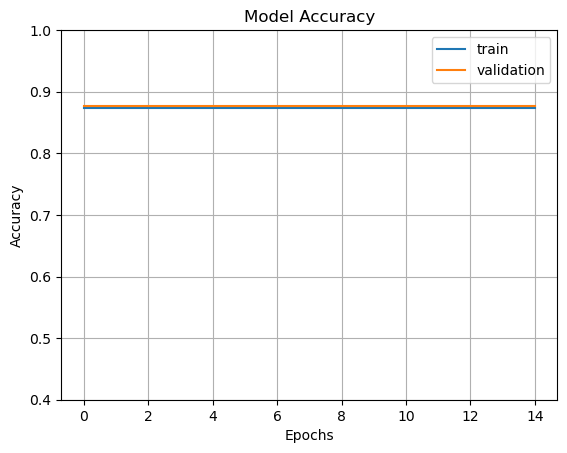

In [166]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

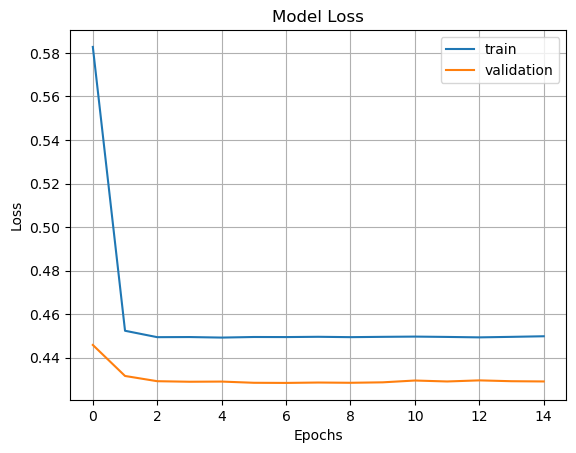

In [167]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [168]:
def predict(model, img):
    img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class= class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


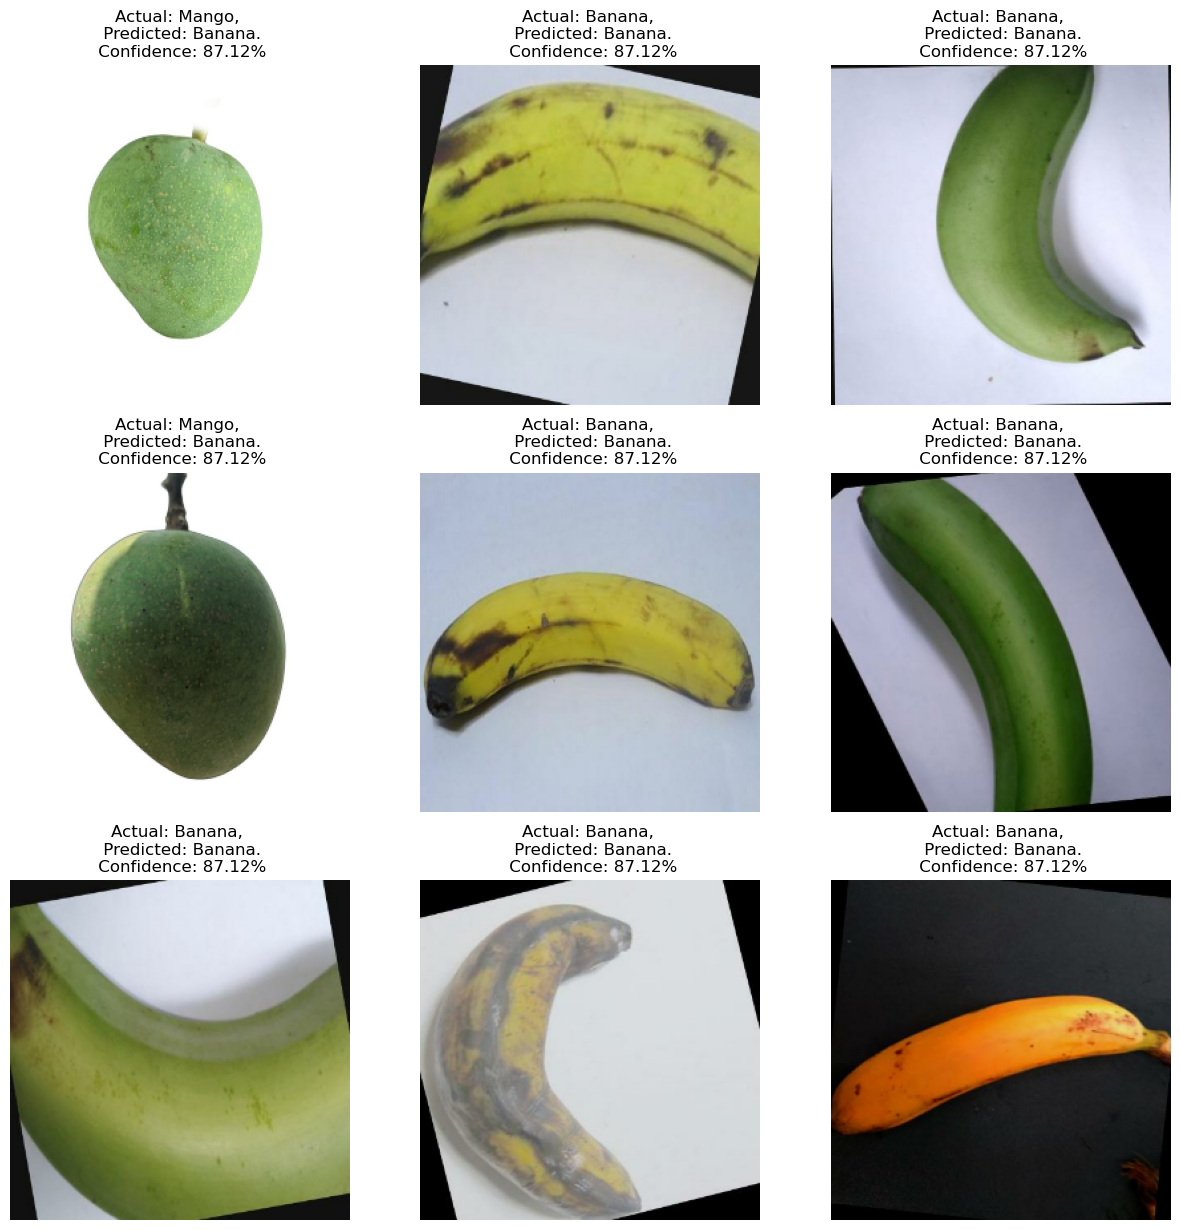

In [169]:
import numpy as np
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence= predict(model, images[i].numpy())
        actual_class= class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis('off')